## Homework 1:
##### In this project, we will be analyzing the monthly page visits to different Wikipedia pages of movies, as listed in the dataset provided. Part of this file uses code developed by Dr. David W. McDonald for use in DATA 512, a course in the UW MS Data Science degree program. This code is provided under the [Creative Commons](https://creativecommons.org) [CC-BY license](https://creativecommons.org/licenses/by/4.0/). Revision 1.2 - August 14, 2023

### Step 1: Setting up the API call function to get information about the Wikipedia page.

##### 1.1 Importing required libraries



In [106]:
# These are standard python modules
import json, time, urllib.parse

# The 'requests' module is not a standard Python module. Might need to install with pip/pip3. 
import requests

import pandas as pd
from collections import defaultdict
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

##### 1.2 Defining constants for the API call

In [107]:
# The REST API 'pageviews' URL - this is the common URL/endpoint for all 'pageviews' API requests
API_REQUEST_PAGEVIEWS_ENDPOINT = 'https://wikimedia.org/api/rest_v1/metrics/pageviews/'

# This is a parameterized string that specifies what kind of pageviews request we are going to make
# In this case it will be a 'per-article' based request. The string is a format string so that we can
# replace each parameter with an appropriate value before making the request
API_REQUEST_PER_ARTICLE_PARAMS = 'per-article/{project}/{access}/{agent}/{article}/{granularity}/{start}/{end}'

# The Pageviews API asks that we not exceed 100 requests per second, we add a small delay to each request
API_LATENCY_ASSUMED = 0.002       # Assuming roughly 2ms latency on the API and network
API_THROTTLE_WAIT = (1.0/100.0)-API_LATENCY_ASSUMED

# When making a request to the Wikimedia API they ask that you include your email address which will allow them
# to contact you if something happens - such as - your code exceeding rate limits - or some other error 
REQUEST_HEADERS = {
    'User-Agent': '<mzameer@uw.edu>, University of Washington, MSDS DATA 512 - AUTUMN 2023',
}

# This template is used to map parameter values into the API_REQUST_PER_ARTICLE_PARAMS portion of an API request. The dictionary has a
# field/key for each of the required parameters. In the example, below, we only vary the article name, so the majority of the fields
# can stay constant for each request. Of course, these values *could* be changed if necessary.
ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE = {
    "project":     "en.wikipedia.org",
    "access":      "desktop",      # this should be changed for the different access types
    "agent":       "user",
    "article":     "",             # this value will be set/changed before each request
    "granularity": "monthly",
    "start":       "2015010100",   # start and end dates need to be set
    "end":         "2023040100"    # this is likely the wrong end date
}

#### Step 3:  Defining the API call function

In [114]:
def request_pageviews_per_article(article_title = None, 
                                  endpoint_url = API_REQUEST_PAGEVIEWS_ENDPOINT, 
                                  endpoint_params = API_REQUEST_PER_ARTICLE_PARAMS, 
                                  request_template = ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE,
                                  safe = "",
                                  headers = REQUEST_HEADERS):

    # article title can be as a parameter to the call or in the request_template
    if article_title:
        request_template['article'] = article_title

    if not request_template['article']:
        raise Exception("Must supply an article title to make a pageviews request.")

    # Titles are supposed to have spaces replaced with "_" and be URL encoded
    article_title_encoded = urllib.parse.quote(request_template['article'].replace(' ','_'))
    request_template['article'] = article_title_encoded
    
    # now, create a request URL by combining the endpoint_url with the parameters for the request
    request_url = endpoint_url+endpoint_params.format(**request_template)
    
    # make the request
    try:
        # we'll wait first, to make sure we don't exceed the limit in the situation where an exception
        # occurs during the request processing - throttling is always a good practice with a free
        # data source like Wikipedia - or other community sources
        if API_THROTTLE_WAIT > 0.0:
            time.sleep(API_THROTTLE_WAIT)
        response = requests.get(request_url, headers=headers)
        json_response = response.json()
    except Exception as e:
        print(e)
        json_response = None
    return json_response

### Step 2: Setting up the Dataset of Movies

In [109]:
movies = pd.read_excel('data/thank_the_academy.AUG.2023.xlsx')


### Step 3: For each Access Type, Iterate through all Movies and process the API call

##### 3.1: For each access type, get data about movies

In [115]:
accesstype = ['desktop', 'mobile-app', 'mobile-web']

def get_movies_data(accesstype):
    ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE['access'] = accesstype
    results = []

    for movie in tqdm(movies['name']):
        try:
            views = request_pageviews_per_article(article_title = movie, request_template = ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE)
            for item in views['items']:
                views_dict = {a:b for a,b in item.items() if a in ["project","article","granularity","timestamp","agent","views"]}
                
                results.append(views_dict)
        except Exception as e:
            print(e, " Could not access data for ",movie)
    
    df = pd.DataFrame(results)

    return results, df

##### 3.2: Fetch and store desktop views and save as file

In [116]:
desktop_dict, desktop_df = get_movies_data(accesstype = "desktop")

with open("data/academy_monthly_desktop_201507_202309.json", "w") as outfile:
    json.dump(desktop_dict, outfile, indent = 2)


 43%|████▎     | 583/1359 [08:27<11:57,  1.08it/s]

'items'  Could not access data for  Victor/Victoria


100%|██████████| 1359/1359 [18:59<00:00,  1.19it/s]


##### 3.3: Fetch and store mobile views and save as file

In [117]:
mobapp_dict, mobapp_df = get_movies_data(accesstype = "mobile-app")
mobweb_dict, mobweb_df = get_movies_data(accesstype = "mobile-web")

 43%|████▎     | 583/1359 [11:50<15:13,  1.18s/it]

'items'  Could not access data for  Victor/Victoria


 43%|████▎     | 583/1359 [11:12<13:06,  1.01s/it]

'items'  Could not access data for  Victor/Victoria


100%|██████████| 1359/1359 [26:30<00:00,  1.17s/it]


In [124]:
desktop_df['date'] = pd.to_datetime(desktop_df['timestamp'], format = '%Y%m%d%H')

mobile_df = mobapp_df.copy()
mobile_df['views'] = mobapp_df['views'] + mobweb_df['views']

mobile_df.to_json("data/academy_monthly_mobile_201507_202309.json",orient='records',indent = 2)
mobile_df['date'] = pd.to_datetime(mobile_df['timestamp'], format = '%Y%m%d%H')


##### 3.4: Calculate Cumulative Views and store as file

In [127]:
total_df = desktop_df.copy()
total_df['views'] = mobile_df['views'] + total_df['views']

# Adding new column to include Cummulative Sum
total_df['cumsum'] =  total_df.groupby(['article'])['views'].cumsum()

total_df.to_json("data/academy_cumulative_201507_202309.json",orient='records',indent = 2)
total_df['date'] = pd.to_datetime(total_df['timestamp'], format = '%Y%m%d%H')

### Step 4: Analysis Results

##### 4.1: Maximum Average and Minimum Average
##### The first graph contains time series for the articles that have the highest average monthly page requests and the lowest average monthly page requests for desktop access and mobile access. The graph has four lines (max desktop, min desktop, max mobile, min mobile).

In [151]:
desktop_agg = desktop_df.groupby('article')["views"].agg({'mean'})
mobile_agg = desktop_df.groupby('article')["views"].agg({'mean'})
min_and_max_movies_desktop = desktop_agg[(desktop_agg['mean'] == desktop_agg["mean"].min()) | (desktop_agg['mean'] == desktop_agg["mean"].max())]
min_and_max_movies_mobile = mobile_agg[(mobile_agg['mean'] == mobile_agg["mean"].min()) | (mobile_agg['mean'] == mobile_agg["mean"].max())]

min_max_desktop = desktop_df[desktop_df['article'].isin(min_and_max_movies_desktop.index)]
min_max_desktop = min_max_desktop.assign(access='desktop')
min_max_mobile = mobile_df[mobile_df['article'].isin(min_and_max_movies_mobile.index)]
min_max_mobile = min_max_mobile.assign(access='mobile')


Text(0.5, 1.0, 'Maximum Average and Minimum Average')

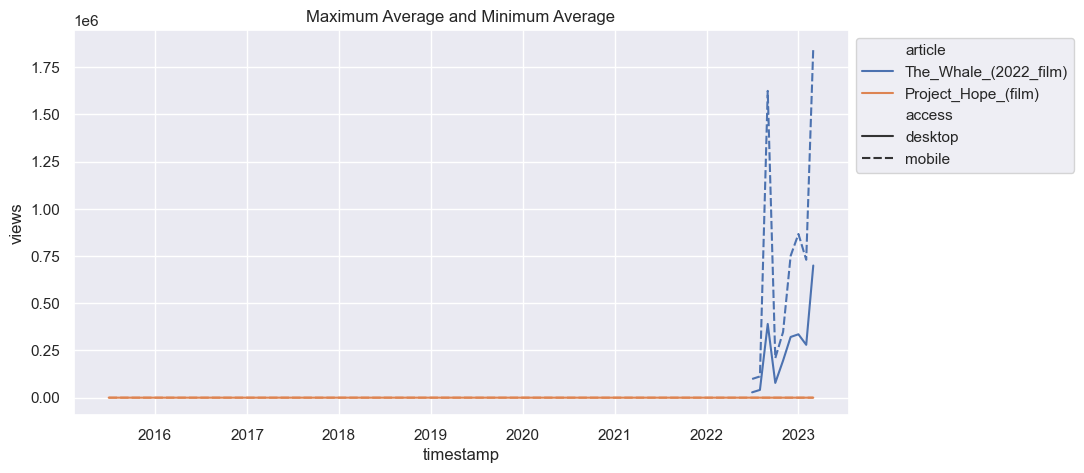

In [158]:
min_max_df = pd.concat([min_max_desktop,min_max_mobile])
plt.figure(figsize=(10,5))
ax = sns.lineplot(x="timestamp", y="views", hue="article", style="access", data=min_max_df)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1), ncol=1)
plt.title("Maximum Average and Minimum Average")

##### 4.2: Top 10 Peak Page Views

##### The second graph contains time series for the top 10 article pages by largest (peak) page views over the entire time by access type. The graph has the top 10 for desktop and top 10 for mobile access (20 lines).

In [164]:
top_10_movies_desktop = desktop_df.groupby("article")["views"].agg('max').sort_values(ascending=False).head(10)
top_10_movies_mobile = mobile_df.groupby("article")["views"].agg('max').sort_values(ascending=False).head(10)

top_10_desktop = desktop_df[desktop_df['article'].isin(top_10_movies_desktop.index)]
top_10_desktop = top_10_desktop.assign(access='desktop')
top_10_mobile = mobile_df[mobile_df['article'].isin(top_10_movies_mobile.index)]
top_10_mobile = top_10_mobile.assign(access='mobile')

top_10_df = pd.concat([top_10_desktop,top_10_mobile])

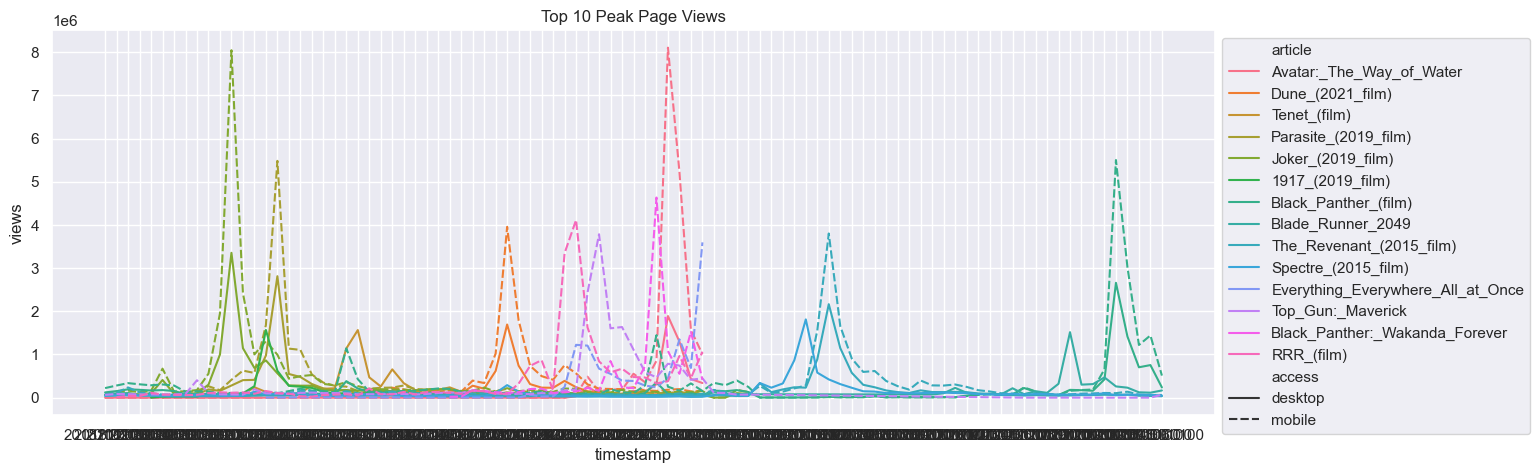

In [166]:
plt.figure(figsize=(15,5))
ax = sns.lineplot(x="timestamp", y="views", hue="article", style="access", data=top_10_df, legend='full');
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.title("Top 10 Peak Page Views")
plt.savefig("results/Top 10 Peak Page Views.png")

##### 4.3: Fewest Months of Data

##### The third graph show pages that have the fewest months of available data. These will all be relatively short time series, some may only have one month of data. The graph shows the 10 articles with the fewest months of data for desktop access and the 10 articles with the fewest months of data for mobile access.

In [168]:
desktop_fewest_movies = desktop_df.groupby("article")["views"].agg('count').sort_values(ascending=True).head(10)
mobile_fewest_movies = mobile_df.groupby("article")["views"].agg('count').sort_values(ascending=True).head(10)

fewest_desktop = desktop_df[desktop_df['article'].isin(desktop_fewest_movies.index)]
fewest_desktop = fewest_desktop.assign(access='desktop')
fewest_mobile = mobile_df[mobile_df['article'].isin(mobile_fewest_movies.index)]
fewest_mobile = fewest_mobile.assign(access='mobile')

fewest_df = pd.concat([fewest_desktop,fewest_mobile])


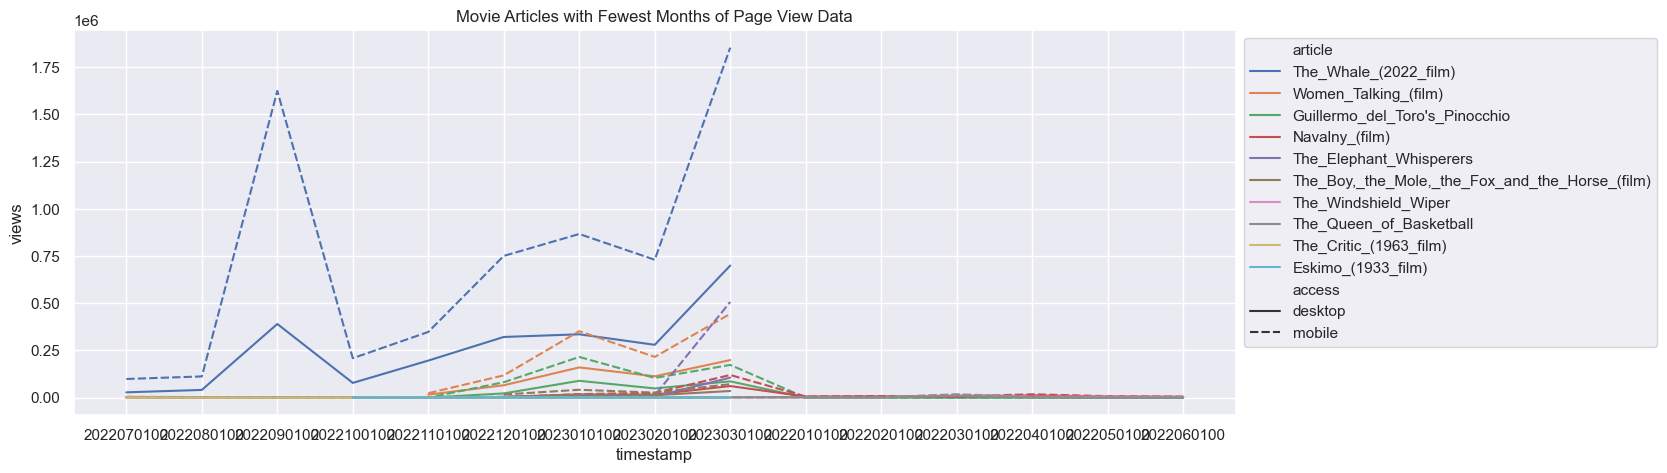

In [179]:
plt.figure(figsize=(15,5))
ax = sns.lineplot(x="timestamp", y="views", hue="article", style="access", data=fewest_df, legend='full');
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.title("Movie Articles with Fewest Months of Page View Data")
plt.savefig("results/Fewest Months of Data.png")